*Name: Mennatullah Ahmed Hamdy Awadallah*
*email: m.awadallah@innopolis.university*

# **Introduction to machine learning assignment1:**

### 1.1 Preprocess data
#### 1.1.1 Encode categorical values:
We'll use ordinal encoding here:

In [459]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
%matplotlib inline

dataset = pd.read_csv("a1_dataset.csv")

encoder = OrdinalEncoder()
column_names = ['var3','var6']
encoder.fit(dataset[column_names])
dataset[column_names] = encoder.transform(dataset[column_names])
dataset.drop('var7', axis=1, inplace=True)
dataset.describe()

,target,var1,var2,var3,var4,var5,var6
count,925.000000,925.000000,925.000000,925.000000,325.000000,925.000000,925.000000
mean,0.496216,360.116562,548.390134,114.643243,108.452308,325.393946,0.522162
std,0.500256,87.866662,135.221460,69.648859,26.325744,78.862779,0.499779
min,0.000000,209.560000,139.965000,0.000000,57.000000,163.000000,0.000000
25%,0.000000,278.640000,467.373000,54.000000,87.000000,257.900000,0.000000
50%,0.000000,367.640000,569.841000,112.000000,105.000000,342.350000,1.000000
75%,1.000000,437.600000,652.278000,176.000000,126.000000,393.000000,1.000000
max,1.000000,539.920000,794.848000,235.000000,180.000000,457.150000,1.000000


#### 1.1.2 Data Imputation:
##### Separate the rows with non-existent var4

In [460]:
NullDS = dataset[dataset["var4"].isna()].copy()
NullDS.drop(["var4"], inplace=True, axis=1)
dataset.dropna(inplace=True)
NullDS.describe()

,target,var1,var2,var3,var5,var6
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.490000,363.720633,549.654728,115.500000,328.504333,0.523333
std,0.500317,85.900554,137.429378,70.795787,79.148597,0.499872
min,0.000000,210.080000,139.965000,0.000000,163.000000,0.000000
25%,0.000000,286.215000,472.362250,52.000000,262.487500,0.000000
50%,0.000000,372.220000,574.727500,114.000000,348.375000,1.000000
75%,1.000000,439.395000,651.969000,180.250000,393.875000,1.000000
max,1.000000,539.920000,794.848000,235.000000,456.850000,1.000000


##### Linear regression for var 4

In [461]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

trainingDS = dataset
corr = trainingDS.corr()['var4'].abs().sort_values(ascending=False)
Xs = corr[corr > 0.2].index.to_list()[1:]
X = dataset[Xs]
Y = trainingDS.var4.values

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, shuffle=True)
LR = LinearRegression()
LR.fit(x_train, y_train)
linearVar4 = LR.predict(x_test)
print("Linear regression:")
print("\tRoot Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, linearVar4) ) )
print('\n')

Linear regression:
	Root Mean Squared Error: 23.31169708749716




##### Polynomial regression for var4

In [462]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


for i in range(2,5):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
    PR = make_pipeline(PolynomialFeatures(i), LinearRegression())
    PR.fit(x_train, y_train)
    polynomialVar4 = PR.predict(x_test)

    print(f"Polynomial Regression of {i} degree:")
    print("\tRoot Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test,polynomialVar4) ) )
    print('\n')

Polynomial Regression of 2 degree:
	Root Mean Squared Error: 18.719362199797484


Polynomial Regression of 3 degree:
	Root Mean Squared Error: 22.162261338432362


Polynomial Regression of 4 degree:
	Root Mean Squared Error: 50.777727273166384




*From the output, we can observe that 2nd degree polynomial regression had the least mean squared error, so we'll use it to predict the missing variables of var4.*

In [463]:
PR = make_pipeline(PolynomialFeatures(2), LinearRegression())
PR.fit(X,Y)
polynomialVar4 = PR.predict(NullDS[Xs])
NullDS['var4'] = polynomialVar4
dataset = pd.concat([dataset, NullDS])
dataset.describe()

,target,var1,var2,var3,var4,var5,var6
count,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000
mean,0.496216,360.116562,548.390134,114.643243,108.565319,325.393946,0.522162
std,0.500256,87.866662,135.221460,69.648859,20.750980,78.862779,0.499779
min,0.000000,209.560000,139.965000,0.000000,43.372973,163.000000,0.000000
25%,0.000000,278.640000,467.373000,54.000000,94.787133,257.900000,0.000000
50%,0.000000,367.640000,569.841000,112.000000,108.000000,342.350000,1.000000
75%,1.000000,437.600000,652.278000,176.000000,123.769325,393.000000,1.000000
max,1.000000,539.920000,794.848000,235.000000,180.000000,457.150000,1.000000


#### 1.1.3 Implementing the PCA technique:

In [464]:
# ps: this PCA class is inspired from online resources, but I understand it

class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        # covariance, functions needs samples as columns
        cov = np.cov(X.T)

        # eigenvectors, eigenvalues
        eigenvectors, eigenvalues = np.linalg.eig(cov)

        # eigenvectors v = [:, i] column vector, transpose this for easier calculations
        eigenvectors = eigenvectors.T

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        # projects data
        X = X - self.mean
        return np.dot(X, self.components.T)

Shape of X: (925, 6)
Shape of transformed X: (925, 2)


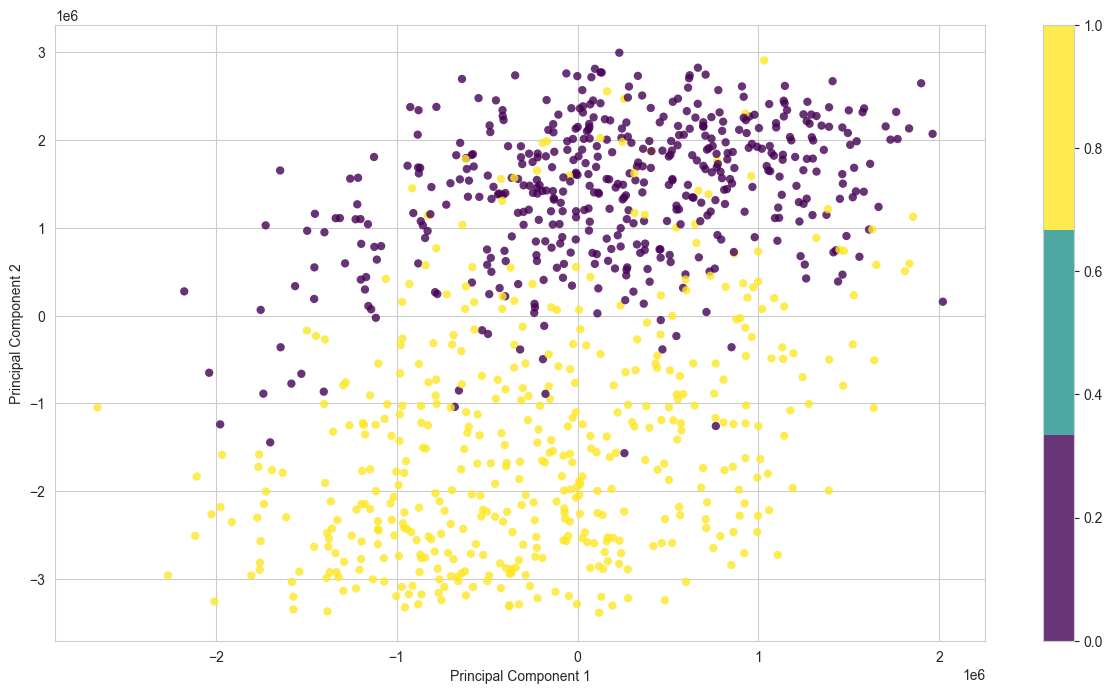

In [465]:
import matplotlib.pyplot as plt
Y = dataset.target.values
X = dataset.drop(['target'], axis = 1)

pca = PCA(2)
pca.fit(X)
X_projected = pca.transform(X)

print("Shape of X:", X.shape)
print("Shape of transformed X:", X_projected.shape)

x1 = X_projected[:, 0]
x2 = X_projected[:, 1]

plt.scatter(
    x1, x2, c=Y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()


### 1.2 Training

In [466]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

models = {}
corr = dataset.corr()['target'].abs().sort_values(ascending=False)
Xs = corr[corr > 0.2].index.to_list()[1:]
print(Xs)
def train_for_target(model, X, Y, is_PCA, is_scaled, params):

    x_train, x_test, y_train, y_test = train_test_split(X, Y)
    if is_PCA:
        pca = PCA(2)
        pca.fit(x_train)
        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)

    if is_scaled:
        scale = MinMaxScaler()
        x_train = scale.fit_transform(x_train)
        x_test = scale.transform(x_test)

    grid_search = GridSearchCV(estimator=model, cv=3, scoring='accuracy', param_grid=params)
    grid_search.fit(x_train, y_train)

    yPred = grid_search.predict(x_test)
    accuracy = accuracy_score(y_test, yPred)

    return accuracy

['var1', 'var5', 'var4', 'var2']


#### 1.2.1 Logistic Regression

In [467]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0)
params = {
    'C': [5, 1, 0.5, 0.1],
    'max_iter': [500, 1000, 2000]
}
Y = dataset.target.values
X = dataset.drop(['target'], axis = 1)

# logistic regression with no PCA, no scaling
accuracy = train_for_target( LR, X, Y, False, False, params)
models['LR'] = accuracy

# logistic regression with PCA, no scaling
accuracy = train_for_target( LR, X, Y, is_PCA=True, is_scaled=False, params=params)
models['LR_PCA'] = accuracy

# logistic regression with PCA, scaling
accuracy = train_for_target( LR, X, Y, is_PCA=False, is_scaled=True, params=params)
models['LR_SCALED'] = accuracy


#### 1.2.2 KNN

In [468]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
params = {'n_neighbors':range(1, 11),
              'weights':['uniform', 'distance'],
              'metric':['manhattan', 'euclidean', 'chebyshev', 'cosine'] }
Y = dataset.target.values
X = dataset.drop(['target'], axis = 1)

# KNN with no PCA, no scaling
accuracy = train_for_target( knn, X, Y, False, False, params)
models['KNN'] = accuracy

# KNN with PCA, no scaling
accuracy = train_for_target( knn, X, Y, True, is_scaled=False, params=params)
models['KNN_PCA'] = accuracy

# KNN with PCA, scaling
accuracy = train_for_target( knn, X, Y, is_PCA=False, is_scaled=True, params=params)
models['KNN_SCALED'] = accuracy


#### 1.2.3 Naive bayes

In [469]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gauss_nb = GaussianNB()
params = {"var_smoothing": [1e-12, 1e-9, 1e-6, 1e-3]}
Y = dataset.target.values
X = dataset.drop(['target'], axis = 1)

# naive bayes with no PCA, no scaling
accuracy = train_for_target(gauss_nb, X, Y, False, False, params)
models['NB'] = accuracy

# naive bayes with PCA, no scaling
accuracy = train_for_target(gauss_nb, X, Y, is_PCA=True, is_scaled=False, params = params)
models['NB_PCA'] = accuracy

# naive bayes with PCA, scaling
accuracy = train_for_target(gauss_nb, X, Y, is_PCA=False, is_scaled=True, params = params)
models['NB_SCALED'] = accuracy

Graph the accuracies and compare the models' performance:

Graph of accuracies of the models run for target:



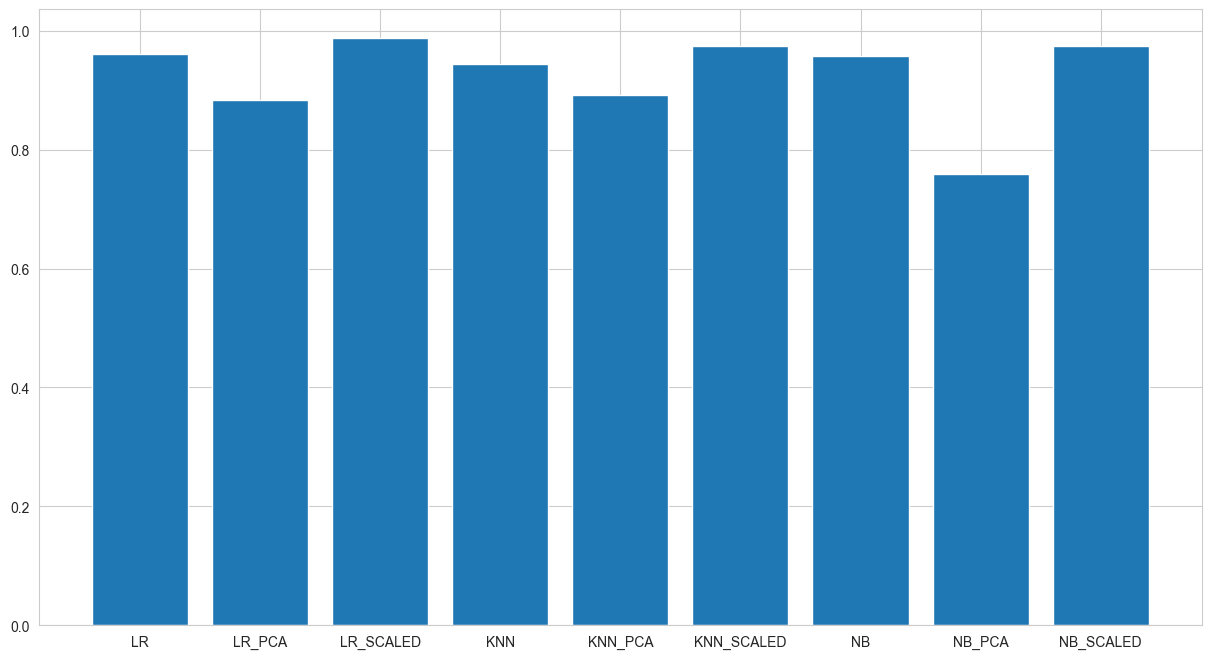

{'LR': 0.9612068965517241,
 'LR_PCA': 0.8836206896551724,
 'LR_SCALED': 0.9870689655172413,
 'KNN': 0.9439655172413793,
 'KNN_PCA': 0.8922413793103449,
 'KNN_SCALED': 0.9741379310344828,
 'NB': 0.9568965517241379,
 'NB_PCA': 0.7586206896551724,
 'NB_SCALED': 0.9741379310344828}

In [470]:
print ("Graph of accuracies of the models run for target:\n")
plt.bar(models.keys(), models.values())
plt.rcParams["figure.figsize"] = (15,8)
plt.show()
models

We can conclude that the scaled Naive bayes had the best results.